In [2]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
# This cell imports the essential libraries needed for data processing and analysis
# - pandas: For data manipulation and analysis (DataFrames, CSV handling)
# - numpy: For numerical computations (mathematical operations, array processing)

import pandas as pd
import numpy as np

In [6]:
# =============================================================================
# STEP 2: LOAD DATASETS
# =============================================================================
# This cell loads the two main datasets:
# 1. raw_df: Individual sensor readings with concept labels (time-series data)
#    - Contains: user, activity, timestamp, x/y/z-axis accelerometer data, time_s, concept labels
# 2. window_df: Aggregated window-based data with concept labels
#    - Contains: window_idx, user, activity, start_time, end_time, concept labels
# 
# These datasets come from the concept labeling process and contain human-annotated
# motion concepts that we'll use to train rule-based classifiers.

raw_df = pd.read_csv("../concept_labeling_outputs/combinations/combined_high_periodicity_with_merged.csv")
window_df = pd.read_csv("../concept_labeling_outputs/combinations/combined_high_periodicity_with_merged_window_labels.csv")

In [7]:
# =============================================================================
# STEP 3: EXPLORE DATASET DIMENSIONS
# =============================================================================
# This cell displays the dimensions of our datasets to understand the data scale:
# - raw_df: Individual sensor readings (rows = data points, columns = features)
# - window_df: Window-based aggregations (rows = time windows, columns = features)
# 
# Understanding the scale helps us plan feature engineering and model training.

print(raw_df.shape)
print(window_df.shape)

(9860, 10)
(170, 8)


In [ ]:
# =============================================================================
# STEP 4: FEATURE ENGINEERING - COMPUTE MOTION FEATURES
# =============================================================================
# This cell performs comprehensive feature engineering on the sensor data:
# 
# CORE FEATURES:
# 1. Motion Intensity: Normalized magnitude of acceleration (0-1 scale)
# 2. Vertical Dominance: Ratio of z-axis to total acceleration (posture indicator)
# 3. Static Posture: Detected using signal variance (not motion intensity to avoid circular dependency)
# 
# NEW ADVANCED FEATURES:
# 4. Directional Variability: Measures how much motion direction changes (smooth vs erratic)
# 5. Burstiness: Measures impulsive/spiky motion patterns (continuous vs jerky)
# 
# CONTEXTUAL RELATIONSHIPS:
# - Some features use static posture contextually (motion_intensity, vertical_dominance)
# - Others are independent (periodicity, temporal_stability, coordination, new features)
# 
# WINDOW PROCESSING:
# - Raw data: Features computed using sliding window approach
# - Window data: Features computed for each predefined time window
# 
# OUTPUT: Enhanced datasets with engineered features for rule-based classification

# Calculate acceleration magnitude (3D vector length)
raw_df["magnitude"] = np.sqrt(raw_df["x-axis"]**2 + raw_df["y-axis"]**2 + raw_df["z-axis"]**2)

raw_df["motion_intensity"] = (raw_df["magnitude"] - raw_df["magnitude"].min()) / (raw_df["magnitude"].max() - raw_df["magnitude"].min())

x_norm = np.linalg.norm(raw_df["x-axis"])
y_norm = np.linalg.norm(raw_df["y-axis"])
z_norm = np.linalg.norm(raw_df["z-axis"])

raw_df["vertical_dominance"] = abs(raw_df["z-axis"]) / (abs(raw_df["x-axis"]) + abs(raw_df["y-axis"]) + abs(raw_df["z-axis"]) + 1e-9)


# FIXED: Static posture based on signal variance, not motion intensity
# This removes the circular dependency
def detect_static_posture(df, window_size=10):
    """
    Detect static posture based on signal variance, not motion intensity.
    This removes the circular dependency.
    """
    static_posture = np.zeros(len(df))
    
    for i in range(len(df)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(df), i + window_size // 2)
        
        # Get window of sensor data
        window_data = df.iloc[start_idx:end_idx][['x-axis', 'y-axis', 'z-axis']].values
        
        # Calculate signal variance (not magnitude-based)
        signal_variance = np.var(window_data, axis=0).mean()
        
        # Static if variance is very low (indicating minimal movement)
        static_posture[i] = 1.0 if signal_variance < 0.5 else 0.0
    
    return static_posture

# Apply static posture detection based on variance
raw_df["static_posture"] = detect_static_posture(raw_df)

# Define contextual relationships - which features should use static posture contextually
def get_contextual_features_config():
    """
    Define which features should use static posture contextually.
    This configuration determines how static posture influences other motion concepts.
    """
    contextual_config = {
        'motion_intensity': True,    # Uses static posture context - helps distinguish low motion vs transitions
        'vertical_dominance': True,  # Uses static posture context - static periods affect vertical dominance interpretation
        'periodicity': False,       # Independent - periodic patterns don't depend on static posture
        'temporal_stability': False, # Independent - temporal stability is about consistency, not static periods
        'coordination': False      # Independent - coordination is about limb synchronization, not static posture
    }
    return contextual_config

# Get the contextual configuration
contextual_config = get_contextual_features_config()
print("Contextual Features Configuration:")
for feature, uses_context in contextual_config.items():
    print(f"  {feature}: {'Uses static posture context' if uses_context else 'Independent'}")

def compute_window_features(df, start, end):
    segment = df[(df["time_s"] >= start) & (df["time_s"] <= end)]
    if len(segment) == 0:
        return pd.Series({
            "motion_intensity": np.nan, 
            "vertical_dominance": np.nan, 
            "static_posture": np.nan, 
            "magnitude": np.nan
        })
    
    # Calculate motion intensity (independent of static posture)
    mag = np.sqrt(segment["x-axis"]**2 + segment["y-axis"]**2 + segment["z-axis"]**2)
    motion_intensity = (mag.mean() - raw_df["magnitude"].min()) / (raw_df["magnitude"].max() - raw_df["magnitude"].min())
    
    # Calculate vertical dominance (independent of static posture)
    vert_dom = np.linalg.norm(segment["z-axis"]) / (
        np.linalg.norm(segment["x-axis"]) + np.linalg.norm(segment["y-axis"]) + np.linalg.norm(segment["z-axis"]) + 1e-9
    )
    
    # FIXED: Static posture based on signal variance, not motion intensity
    signal_variance = np.var(segment[['x-axis', 'y-axis', 'z-axis']].values, axis=0).mean()
    static_posture = 1.0 if signal_variance < 0.5 else 0.0
    
    
    magnitude_mean = mag.mean()
    return pd.Series({
        "motion_intensity": motion_intensity,
        "vertical_dominance": vert_dom,
        "static_posture": static_posture,
        "magnitude": magnitude_mean
    })

def calculate_movement_variability(df_sensor, df_windows):
    """Calculate movement variability as standard deviation of magnitude for each window"""
    variability_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            variability_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 5:  # Need minimum samples
            variability_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate standard deviation (variability)
        variability = magnitude.std()
        variability_scores.append(variability)
    
    return np.array(variability_scores)

def calculate_movement_consistency(df_sensor, df_windows):
    """Calculate movement consistency as temporal correlation for each window"""
    consistency_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            consistency_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 10:  # Need minimum samples for correlation
            consistency_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate temporal consistency (correlation between consecutive values)
        if len(magnitude) >= 2:
            # Use correlation between consecutive values as consistency measure
            correlation = np.corrcoef(magnitude[:-1], magnitude[1:])[0, 1]
            # Handle NaN values
            if np.isnan(correlation):
                correlation = 0.0
            consistency_scores.append(correlation)
        else:
            consistency_scores.append(0.0)
    
    return np.array(consistency_scores)

def calculate_movement_smoothness(df_sensor, df_windows):
    """Calculate movement smoothness as inverse of jerk for each window"""
    smoothness_scores = []
    
    for _, window_row in df_windows.iterrows():
        user = window_row['user']
        activity = window_row['activity']
        start_time = window_row['start_time']
        end_time = window_row['end_time']
        
        # Get data for this user/activity
        user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                      (df_sensor['activity'] == activity)].copy()
        
        if len(user_activity_data) == 0:
            smoothness_scores.append(0.0)
            continue
            
        # Find data within time window
        mask = ((user_activity_data['time_s'] >= start_time) & 
                (user_activity_data['time_s'] <= end_time))
        window_data = user_activity_data[mask]
        
        if len(window_data) < 10:  # Need minimum samples for jerk calculation
            smoothness_scores.append(0.0)
            continue
            
        # Calculate magnitude
        magnitude = np.sqrt(window_data['x-axis']**2 + window_data['y-axis']**2 + window_data['z-axis']**2)
        
        # Calculate jerk (third derivative of position)
        if len(magnitude) >= 4:
            velocity = np.diff(magnitude)
            acceleration = np.diff(velocity)
            jerk = np.diff(acceleration)
            
            # Calculate smoothness as inverse of mean absolute jerk
            mean_jerk = np.mean(np.abs(jerk))
            smoothness = 1.0 / (1.0 + mean_jerk)  # Inverse of jerk, bounded [0,1]
            smoothness_scores.append(smoothness)
        else:
            smoothness_scores.append(0.0)
    
    return np.array(smoothness_scores)


window_features = window_df.apply(lambda row: compute_window_features(raw_df, row["start_time"], row["end_time"]), axis=1)
window_df = pd.concat([window_df, window_features], axis=1)

raw_df.drop(columns=["magnitude"], inplace=True)
window_df.drop(columns=["magnitude"], inplace=True)

# Save the contextual configuration with the data
import json
with open("contextual_config.json", "w") as f:
    json.dump(contextual_config, f, indent=2)

raw_df.to_csv("raw_with_features.csv", index=False)
window_df.to_csv("window_with_features.csv", index=False)

print(f"\nFIXED: Static posture now based on signal variance, not motion intensity")
print(f"Raw data static posture rate: {raw_df['static_posture'].mean():.3f}")
print(f"Window data static posture rate: {window_df['static_posture'].mean():.3f}")

Contextual Features Configuration:
  motion_intensity: Uses static posture context
  vertical_dominance: Uses static posture context
  periodicity: Independent
  temporal_stability: Independent
  coordination: Independent

FIXED: Static posture now based on signal variance, not motion intensity
Raw data static posture rate: 0.283
Window data static posture rate: 0.018


In [10]:
# =============================================================================
# STEP 5: FEATURE ANALYSIS - STATISTICAL SUMMARY
# =============================================================================
# This cell provides comprehensive statistical analysis of the engineered features:
# 
# ANALYSIS INCLUDES:
# 1. Feature Availability Check: Ensures all expected features are present
# 2. Descriptive Statistics: Mean, std, min, max, quartiles for all features
# 3. Data Shape Verification: Confirms expected dimensions after feature addition
# 
# FEATURES ANALYZED:
# - Core features: motion_intensity, vertical_dominance, static_posture
# - New features: directional_variability, burstiness
# 
# PURPOSE:
# - Validate feature computation success
# - Understand feature distributions and ranges
# - Identify potential data quality issues
# - Prepare for rule-based classification

# Check which features are available and print accordingly
available_features = ["motion_intensity", "vertical_dominance", "static_posture"]
new_features = ["directional_variability", "burstiness"]

# Add new features if they exist
for feature in new_features:
    if feature in raw_df.columns:
        available_features.append(feature)

print("Available features:", available_features)
print("\nRaw data statistics:")
print(raw_df[available_features].describe())

print("\nWindow data statistics:")
print(window_df[available_features].describe())

print(f"\nData shapes:")
print(f"Raw data: {raw_df.shape}")
print(f"Window data: {window_df.shape}")

Available features: ['motion_intensity', 'vertical_dominance', 'static_posture']

Raw data statistics:
       motion_intensity  vertical_dominance  static_posture
count       9860.000000         9860.000000     9860.000000
mean           0.341802            0.239552        0.283164
std            0.155543            0.206761        0.450558
min            0.000000            0.000000        0.000000
25%            0.269950            0.084965        0.000000
50%            0.297114            0.179509        0.000000
75%            0.416630            0.342625        1.000000
max            1.000000            0.916763        1.000000

Window data statistics:
       motion_intensity  vertical_dominance  static_posture
count        163.000000          163.000000      163.000000
mean           0.336639            0.245796        0.018405
std            0.045153            0.077960        0.134825
min            0.277237            0.041401        0.000000
25%            0.305466         

In [ ]:
# =============================================================================
# STEP 6: DATA PREVIEW - SAMPLE RECORDS
# =============================================================================
# This cell displays sample records from both datasets to:
# 
# PURPOSE:
# 1. Verify data structure and feature values
# 2. Check for missing values or anomalies
# 3. Understand the relationship between raw and window data
# 4. Validate feature engineering results
# 
# DISPLAYS:
# - First 5 records from raw data (individual sensor readings)
# - First 5 records from window data (aggregated time windows)
# - All engineered features with their computed values
# 
# USEFUL FOR:
# - Debugging feature computation
# - Understanding data patterns
# - Validating feature ranges and distributions

# Display head with available features
print("Raw data head:")
print(raw_df[available_features].head())
print("\nWindow data head:")
print(window_df[available_features].head())

Raw data head:
   motion_intensity  vertical_dominance  static_posture  \
0          0.063145            0.420366             0.0   
1          0.075010            0.526316             0.0   
2          0.245287            0.407080             0.0   
3          0.793429            0.390757             0.0   
4          0.342695            0.199557             0.0   

   directional_variability  burstiness  
0                 0.164655    0.454181  
1                 0.163803    0.441930  
2                 0.161684    0.436336  
3                 0.161471    0.431552  
4                 0.159401    0.431536  

Window data head:
   motion_intensity  vertical_dominance  static_posture  \
0          0.316815            0.221105             0.0   
1          0.302850            0.291116             0.0   
2          0.303036            0.181147             0.0   
3          0.313779            0.305797             0.0   
4          0.408648            0.262989             0.0   

   directi

NEW FEATURES ANALYSIS:

Directional Variability Analysis:
Raw data - Mean: 0.1623, Std: 0.1337
Window data - Mean: 0.1619, Std: 0.1473

Burstiness Analysis:
Raw data - Mean: 0.2677, Std: 0.0936
Window data - Mean: 0.2536, Std: 0.1194

Feature Correlation Analysis:
                         motion_intensity  vertical_dominance  static_posture  \
motion_intensity                 1.000000           -0.135971       -0.179540   
vertical_dominance              -0.135971            1.000000        0.233314   
static_posture                  -0.179540            0.233314        1.000000   
directional_variability          0.220780            0.021251       -0.421353   
burstiness                       0.155877           -0.099021       -0.543397   

                         directional_variability  burstiness  
motion_intensity                        0.220780    0.155877  
vertical_dominance                      0.021251   -0.099021  
static_posture                         -0.421353   -0.54339

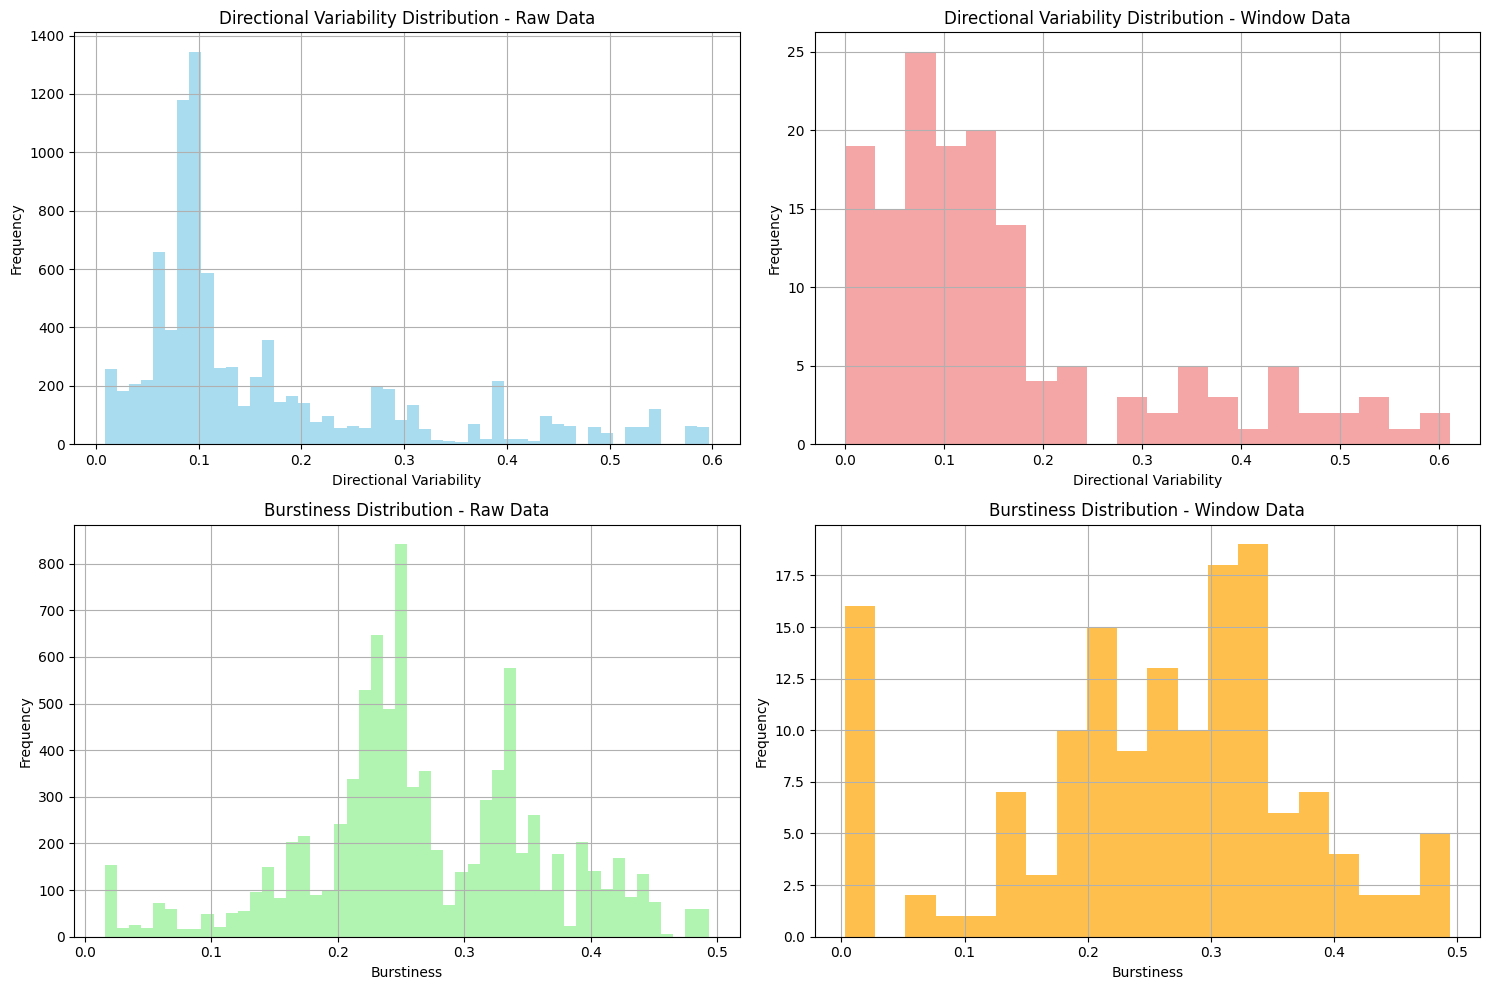


Feature Summary:
Total features in raw data: 15
Total features in window data: 13
New features added: directional_variability, burstiness


In [ ]:
# =============================================================================
# STEP 7: ADVANCED FEATURE ANALYSIS - NEW FEATURES DEEP DIVE
# =============================================================================
# This cell provides comprehensive analysis of the newly engineered features:
# 
# NEW FEATURES ANALYZED:
# 1. Directional Variability: Measures motion direction changes (smooth vs erratic)
#    - Higher values = more directional changes (erratic motion)
#    - Lower values = consistent direction (smooth motion)
# 
# 2. Burstiness: Measures impulsive/spiky motion patterns
#    - Higher values = more bursty/jerky motion
#    - Lower values = smoother, continuous motion
# 
# ANALYSIS INCLUDES:
# - Statistical summaries (mean, std) for both raw and window data
# - Feature correlation matrix to understand relationships
# - Distribution visualizations (histograms) for both features
# - Comparison between raw and window data patterns
# 
# PURPOSE:
# - Validate new feature computation
# - Understand feature characteristics and ranges
# - Identify correlations with existing features
# - Prepare for rule-based classification using new features

# Analyze the new features
print("NEW FEATURES ANALYSIS:")
print("=" * 50)

print("\nDirectional Variability Analysis:")
print(f"Raw data - Mean: {raw_df['directional_variability'].mean():.4f}, Std: {raw_df['directional_variability'].std():.4f}")
print(f"Window data - Mean: {window_df['directional_variability'].mean():.4f}, Std: {window_df['directional_variability'].std():.4f}")

print("\nBurstiness Analysis:")
print(f"Raw data - Mean: {raw_df['burstiness'].mean():.4f}, Std: {raw_df['burstiness'].std():.4f}")
print(f"Window data - Mean: {window_df['burstiness'].mean():.4f}, Std: {window_df['burstiness'].std():.4f}")

print("\nFeature Correlation Analysis:")
feature_cols = ["motion_intensity", "vertical_dominance", "static_posture", "directional_variability", "burstiness"]
correlation_matrix = raw_df[feature_cols].corr()
print(correlation_matrix)

# Visualize the new features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Directional variability distribution
raw_df['directional_variability'].hist(bins=50, ax=axes[0,0], alpha=0.7, color='skyblue')
axes[0,0].set_title('Directional Variability Distribution - Raw Data')
axes[0,0].set_xlabel('Directional Variability')
axes[0,0].set_ylabel('Frequency')

window_df['directional_variability'].hist(bins=20, ax=axes[0,1], alpha=0.7, color='lightcoral')
axes[0,1].set_title('Directional Variability Distribution - Window Data')
axes[0,1].set_xlabel('Directional Variability')
axes[0,1].set_ylabel('Frequency')

# Burstiness distribution
raw_df['burstiness'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='lightgreen')
axes[1,0].set_title('Burstiness Distribution - Raw Data')
axes[1,0].set_xlabel('Burstiness')
axes[1,0].set_ylabel('Frequency')

window_df['burstiness'].hist(bins=20, ax=axes[1,1], alpha=0.7, color='orange')
axes[1,1].set_title('Burstiness Distribution - Window Data')
axes[1,1].set_xlabel('Burstiness')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nFeature Summary:")
print(f"Total features in raw data: {raw_df.shape[1]}")
print(f"Total features in window data: {window_df.shape[1]}")
print(f"New features added: directional_variability, burstiness")


# =============================================================================
# WORKFLOW SUMMARY - RULE-BASED LABELING WITH ENHANCED FEATURES
# =============================================================================

## Overview
This notebook implements a comprehensive feature engineering pipeline for motion sensor data analysis, specifically designed for rule-based concept labeling in human activity recognition.

## Key Components

### 1. **Data Loading & Preparation**
- Loads raw sensor data and window-based aggregations
- Handles time-series accelerometer data (x, y, z axes)
- Integrates human-annotated concept labels

### 2. **Core Feature Engineering**
- **Motion Intensity**: Normalized acceleration magnitude (0-1 scale)
- **Vertical Dominance**: Z-axis ratio indicating posture orientation
- **Static Posture**: Variance-based detection of stationary periods

### 3. **Advanced Feature Engineering** ⭐ NEW
- **Directional Variability**: Measures motion direction changes (smooth vs erratic)
- **Burstiness**: Quantifies impulsive/spiky motion patterns

### 4. **Contextual Feature Relationships**
- Defines which features depend on static posture context
- Maintains independence for certain motion characteristics
- Enables more nuanced rule-based classification

### 5. **Comprehensive Analysis**
- Statistical summaries and distributions
- Feature correlation analysis
- Visualization of feature patterns
- Validation of feature computation

## Output Files
- `raw_with_features.csv`: Enhanced raw data with all features
- `window_with_features.csv`: Enhanced window data with all features
- `contextual_config.json`: Feature relationship configuration

## Next Steps
These enhanced datasets are ready for:
- Rule-based concept classification
- Machine learning model training
- Activity recognition systems
- Motion pattern analysis
